In [1]:
import initialize_notebook
import pandas as pd

from ams.DateRange import DateRange
%matplotlib inline
from pathlib import Path

from pyspark.sql import functions as F

from ams.config import constants
from ams.services import spark_service
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Miniconda3\envs\alpha_media_signal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# spark = spark_service.get_or_create('assign_sentiment_and_stock')

In [3]:
twitter_folder = 'twitter'

learning_prep_path = Path(constants.DATA_PATH, twitter_folder, "learning_prep_drop", "learning_prep_drop_2020-09-20_13-29-52-218.1", "part-00000-3d4f75b7-a9eb-4c58-8593-d57ecab7462b-c000.csv")

In [4]:
df_twitter = pd.read_csv(str(learning_prep_path))
# df_twitter = df_twitter.sample(frac=.001)

C:\ProgramData\Miniconda3\envs\alpha_media_signal\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9,16,23,26,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
from ams.services import ticker_service

tickers = df_twitter['f22_ticker'].unique().tolist()

Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal


In [6]:
date_range = DateRange.from_date_strings(from_date_str="2020-08-01", to_date_str="2020-09-30")
df_stock_data = ticker_service.get_tickers_in_range(tickers=tickers, date_range=date_range)
print(f'{df_stock_data.shape[0]}')

83732


In [7]:
df_stock_renamed = df_stock_data.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_stock_clean = df_stock_renamed.drop(columns=['lastupdated'])
print(f'Twitter: {df_twitter.shape[0]}')
print(f'Quandl: {df_stock_renamed.shape[0]}')

print(f'{df_twitter.columns}')
print(f'{df_stock_renamed.columns}')

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

df_merged_clean = df_merged.sample(frac=1.0)

print(f'Num merged: {df_merged.shape[0]}')

Twitter: 3652061
Quandl: 83732
Index(['created_at', 'created_at_timestamp', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score', 'date'], dtype='object')
Index(['f22_ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'lastupdated'], dtype='object')
Num merged: 1218219


In [8]:
from ams.utils import date_utils
import time

df_blue_rabbit = df_merged_clean

df_blue_rabbit.sort_values("f22_ticker", inplace=True)

def get_price_in_days(date_string: str, ticker: str):
    high_price = ticker_service.get_next_trading_day_high(ticker=ticker, date_str=date_string)
    return high_price

start = time.time()
df_blue_rabbit['future_price'] = df_blue_rabbit.apply(lambda x: get_price_in_days(x['date'], x['f22_ticker']), axis=1)
end = time.time()

print(f"Elapsed: {round(end - start, 2)} seconds.")

Elapsed: 371.95 seconds.


In [9]:
from sklearn.preprocessing import StandardScaler

df_blue_rabbit['stock_val_change'] = (df_blue_rabbit['future_price'] - df_blue_rabbit['close']) / df_blue_rabbit['future_price'] * 100.0

scaler = StandardScaler()
df_blue_rabbit['stock_val_change_scaled'] = scaler.fit_transform(df_blue_rabbit[['stock_val_change']])

In [10]:
df_blue_rabbit['buy_sell'] = df_blue_rabbit['stock_val_change_scaled'].apply(lambda x: 1 if x >=0 else -1)

zero_fill_cols = ['created_at_timestamp',
       'favorite_count', 'user_verified',
       'user_listed_count', 'user_time_zone',
       'user_has_extended_profile', 'in_reply_to_status_id',
       'user_statuses_count', 'user_protected', 'user_is_translation_enabled',
       'user_geo_enabled',
       'possibly_sensitive', 'user_friends_count',
       'retweet_count', 'user_follow_request_sent', 'user_followers_count',
       'f22_has_cashtag', 'f22_ticker_in_text',
       'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos',
       'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound',
       'f22_compound_score']

df_blue_rabbit[zero_fill_cols] = df_blue_rabbit[zero_fill_cols].fillna(0)

df_blue_rabbit.head(2)

,created_at,created_at_timestamp,user_screen_name,favorite_count,in_reply_to_screen_name,user_verified,metadata_result_type,user_listed_count,user_time_zone,user_has_extended_profile,in_reply_to_status_id,user_statuses_count,user_protected,user_is_translation_enabled,user_location,lang,user_geo_enabled,place_country,place_name,possibly_sensitive,user_friends_count,retweet_count,user_follow_request_sent,user_followers_count,f22_ticker,f22_has_cashtag,f22_ticker_in_text,f22_num_other_tickers_in_tweet,f22_sentiment_pos,f22_sentiment_neu,f22_sentiment_neg,f22_sentiment_compound,f22_compound_score,date,open,high,low,close,volume,dividends,closeunadj,lastupdated,future_price,stock_val_change,stock_val_change_scaled,buy_sell
513652,Mon Aug 24 15:25:37 +0000 2020,1598282737,QuantchaIdeas,0,NaN,False,recent,35,0.0,False,0.0,59843,False,False,NaN,en,False,NaN,NaN,False,2,1.0,0.0,1225,AAL,False,True,2.0,0.000,0.864,0.136,0.2960,362.6,2020-08-24,12.44,13.48,12.27,13.44,101574487.0,0.0,13.44,2020-08-24,14.02,4.136947,0.601523,1
477497,Mon Aug 17 12:57:32 +0000 2020,1597669052,Stonefoxcapital,0,NaN,False,recent,86,0.0,False,0.0,27842,False,False,Broken Arrow&#44; OK,en,False,NaN,NaN,True,1320,0.0,0.0,1100,AAL,True,True,1.0,0.178,0.822,0.000,-0.0772,-84.92,2020-08-17,13.32,13.38,12.61,12.62,55705663.0,0.0,12.62,2020-08-17,12.88,2.018634,-0.048583,-1


In [11]:
df_green_hornet = df_blue_rabbit.dropna(subset=["f22_ticker"])

empty_fill_cols = ['user_screen_name',
       'in_reply_to_screen_name',
       'metadata_result_type',
       'user_location', 'place_country',
       'place_name']

df_green_hornet[empty_fill_cols] = df_green_hornet[empty_fill_cols].fillna("")
df_green_hornet["lang"] = df_green_hornet["lang"].fillna("en")

print(f"df_green_hornet cols: {df_green_hornet.columns}")

df_green_hornet cols: Index(['created_at', 'created_at_timestamp', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_compound_score', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'lastupdated', 'future_price', 'stock_val_change', 'stock_val_change_scaled', 'buy_sell'], dtype='object')


In [12]:
from typing import List
from pandas.api.types import CategoricalDtype

# If test does not have category, then you'll have a hard time.
def make_one_hotted(df: pd.DataFrame, cols: List[str]):
    df_one_hots = []
    for c in cols:
        uniques = df[c].unique().tolist()
        if len(uniques) > 0:
            df[c] = df[c].astype(CategoricalDtype(uniques))
            # This is one-hot-encoding.
            df_new_cols = pd.get_dummies(df[c], prefix=c)
            df_one_hots.append(df_new_cols)

    df_one_dropped = df.drop(columns=one_hot_cols)
    df_one_hots.append(df_one_dropped)

    return pd.concat(df_one_hots, axis=1)

# one_hot_cols = ['user_screen_name',
#    'in_reply_to_screen_name',
#    'metadata_result_type',
#    'user_location', 'lang', 'place_country',
#    'place_name', 'f22_ticker'
# ]

# NOTE: Supersparse - no one_hot_cols
omit_cols = ['created_at_timestamp', 'in_reply_to_status_id', 'place_country', 'user_time_zone', 'place_name',
             'user_location', 'metadata_result_type', 'user_screen_name', 'place_name, ''place_country', 
             'lang', 'in_reply_to_screen_name', 'lastupdated', 'created_at', 'future_price', 
             'stock_val_change', 'stock_val_change_scaled']
one_hot_cols = []

# NOTE: Sparse - only user_screen_name
# omit_cols = ['created_at_timestamp', 'in_reply_to_status_id', 'place_country', 'user_time_zone', 'place_name',
#              'user_location', 'metadata_result_type', 'user_screen_name', 'place_name, ''place_country', 
#              'lang', 'in_reply_to_screen_name', 'lastupdated', 'date', 'created_at', 'future_price', 
#              'stock_val_change', 'stock_val_change_scaled']
# one_hot_cols = ['user_screen_name']

df_one_hotted = make_one_hotted(df=df_green_hornet, cols=one_hot_cols)

narrow_cols = list(set(df_one_hotted.columns) - set(omit_cols))

print(f"narrow_cols: {narrow_cols}")

sort_by = "f22_ticker" #'created_at_timestamp'
df_one_hotted.sort_values(by=sort_by, ascending=False, inplace=True)

df_hot_narrow = df_one_hotted[narrow_cols]
df_hot_narrow.head()

narrow_cols: ['dividends', 'user_listed_count', 'user_follow_request_sent', 'f22_sentiment_neg', 'user_protected', 'close', 'f22_sentiment_pos', 'f22_sentiment_neu', 'favorite_count', 'user_has_extended_profile', 'volume', 'date', 'f22_ticker_in_text', 'open', 'user_friends_count', 'buy_sell', 'user_geo_enabled', 'closeunadj', 'high', 'low', 'user_followers_count', 'f22_has_cashtag', 'f22_sentiment_compound', 'f22_ticker', 'user_is_translation_enabled', 'possibly_sensitive', 'retweet_count', 'user_statuses_count', 'f22_num_other_tickers_in_tweet', 'user_verified', 'f22_compound_score']


,dividends,user_listed_count,user_follow_request_sent,f22_sentiment_neg,user_protected,close,f22_sentiment_pos,f22_sentiment_neu,favorite_count,user_has_extended_profile,volume,date,f22_ticker_in_text,open,user_friends_count,buy_sell,user_geo_enabled,closeunadj,high,low,user_followers_count,f22_has_cashtag,f22_sentiment_compound,f22_ticker,user_is_translation_enabled,possibly_sensitive,retweet_count,user_statuses_count,f22_num_other_tickers_in_tweet,user_verified,f22_compound_score
1206580,0.0,73,0.0,0.189,False,16.01,0.000,0.811,0,False,578133.0,2020-09-16,True,15.77,40,1,False,16.01,16.400,15.77,1624,True,0.2732,ZYXI,False,False,0.0,1167409,1.0,False,443.677
563744,0.0,1,0.0,0.000,False,15.66,0.113,0.887,0,False,933290.0,2020-08-25,True,15.40,3352,-1,True,15.66,16.100,15.10,479,True,-0.4215,ZYXI,False,0,2.0,32797,1.0,False,-201.899
563743,0.0,99,0.0,0.000,False,15.66,0.113,0.887,0,False,933290.0,2020-08-25,True,15.40,0,-1,False,15.66,16.100,15.10,7030,True,-0.4215,ZYXI,False,0,2.0,859170,1.0,False,-2963.14
571746,0.0,3112,0.0,0.137,False,16.26,0.000,0.863,8,False,538839.0,2020-08-21,True,16.65,1661,-1,True,16.26,16.790,16.10,470734,True,0.4019,ZYXI,False,False,1.0,87491,1.0,False,189188
570134,0.0,5,0.0,0.000,False,18.05,0.112,0.888,0,False,593001.0,2020-08-12,True,18.10,730,-1,False,18.05,18.369,17.71,230,False,-0.2846,ZYXI,False,False,0.0,1661,0.0,False,-65.458


In [31]:
from pandas import DataFrame
from typing import List

def convert_to_bool(df: DataFrame, cols: List[str]):
    for c in cols:
        df = df.astype({c: str})
        df[c] = df[c].apply(lambda x: x.lower().strip())
        df = df.replace({c: {'true': True, 'false': False, '': False, '0': False, '1': True}})
    
    return df

df_cast = convert_to_bool(df_hot_narrow, ['possibly_sensitive', 'f22_ticker_in_text', 'user_verified', 'f22_has_cashtag',
                                          'user_has_extended_profile', 'user_is_translation_enabled', 'f22_ticker_in_text',
                                          'user_protected', 'user_geo_enabled'])

df_cast["original_close_price"] = df_cast["close"]
std_cols = [
       'favorite_count', 
       'user_listed_count',
       'user_statuses_count', 
       'user_friends_count',
       'retweet_count', 'user_follow_request_sent', 'user_followers_count',
       'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos',
       'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound',
       'f22_compound_score', 'open', 'high', 'low', 'close', 'closeunadj', 'volume']

for i, c in enumerate(std_cols):
    df_cast[c] = scaler.fit_transform(df_cast[[c]])
    
df_cast.head()


,dividends,user_listed_count,user_follow_request_sent,f22_sentiment_neg,user_protected,close,f22_sentiment_pos,f22_sentiment_neu,favorite_count,user_has_extended_profile,volume,date,f22_ticker_in_text,open,user_friends_count,buy_sell,user_geo_enabled,closeunadj,high,low,user_followers_count,f22_has_cashtag,f22_sentiment_compound,f22_ticker,user_is_translation_enabled,possibly_sensitive,retweet_count,user_statuses_count,f22_num_other_tickers_in_tweet,user_verified,f22_compound_score,original_close_price
1206580,0.0,-0.027804,0.0,0.120282,False,-0.147913,-0.638982,0.358916,-0.012924,False,-0.218587,2020-09-16,True,-0.148014,-0.135907,1,False,-0.147911,-0.149487,-0.145373,-0.032729,True,0.037032,ZYXI,False,False,-0.134423,3.256503,0.062988,False,-0.013923,16.01
563744,0.0,-0.104899,0.0,-1.234671,False,-0.148676,0.494171,0.940017,-0.012924,False,-0.198434,2020-08-25,True,-0.148823,0.098825,-1,True,-0.148674,-0.150138,-0.146844,-0.038274,True,-1.464749,ZYXI,False,False,-0.134312,-0.217613,0.062988,False,-0.020915,15.66
563743,0.0,0.000036,0.0,-1.234671,False,-0.148676,0.494171,0.940017,-0.012924,False,-0.198434,2020-08-25,True,-0.148823,-0.138742,-1,False,-0.148674,-0.150138,-0.146844,-0.006546,True,-1.464749,ZYXI,False,False,-0.134312,2.312693,0.062988,False,-0.050819,15.66
571746,0.0,3.226281,0.0,-0.252509,False,-0.147367,-0.638982,0.756512,0.006951,False,-0.220817,2020-08-21,True,-0.146090,-0.021022,-1,True,-0.147365,-0.148639,-0.144648,2.239278,True,0.315252,ZYXI,False,False,-0.134367,-0.050143,0.062988,False,2.030165,16.26
570134,0.0,-0.100616,0.0,-1.234671,False,-0.143464,0.484143,0.947663,-0.012924,False,-0.217744,2020-08-12,True,-0.142920,-0.087005,-1,False,-0.143462,-0.145208,-0.141112,-0.039480,False,-1.168803,ZYXI,False,False,-0.134423,-0.312950,-0.676066,False,-0.019437,18.05


In [32]:
df_tmp = df_cast #.sample(frac=.0004)

In [33]:
df_g_counting = df_tmp.groupby(['f22_ticker', 'date'])
s_sized = df_g_counting.size()

df_renamed = s_sized.to_frame().rename(columns={0: 'f22_day_tweet_count'})

df_res = df_tmp.join(df_renamed, on=["f22_ticker", "date"], how="inner")

df_res.head()

,dividends,user_listed_count,user_follow_request_sent,f22_sentiment_neg,user_protected,close,f22_sentiment_pos,f22_sentiment_neu,favorite_count,user_has_extended_profile,volume,date,f22_ticker_in_text,open,user_friends_count,buy_sell,user_geo_enabled,closeunadj,high,low,user_followers_count,f22_has_cashtag,f22_sentiment_compound,f22_ticker,user_is_translation_enabled,possibly_sensitive,retweet_count,user_statuses_count,f22_num_other_tickers_in_tweet,user_verified,f22_compound_score,original_close_price,f22_day_tweet_count
1206580,0.0,-0.027804,0.0,0.120282,False,-0.147913,-0.638982,0.358916,-0.012924,False,-0.218587,2020-09-16,True,-0.148014,-0.135907,1,False,-0.147911,-0.149487,-0.145373,-0.032729,True,0.037032,ZYXI,False,False,-0.134423,3.256503,0.062988,False,-0.013923,16.01,2
1206581,0.0,0.027877,0.0,-0.675484,False,-0.147913,-0.638982,1.207630,-0.012924,False,-0.218587,2020-09-16,True,-0.148014,-0.083390,1,False,-0.147911,-0.149487,-0.145373,-0.010053,True,-0.168984,ZYXI,False,False,-0.134423,2.181630,0.062988,False,-0.006579,16.01,2
563744,0.0,-0.104899,0.0,-1.234671,False,-0.148676,0.494171,0.940017,-0.012924,False,-0.198434,2020-08-25,True,-0.148823,0.098825,-1,True,-0.148674,-0.150138,-0.146844,-0.038274,True,-1.464749,ZYXI,False,False,-0.134312,-0.217613,0.062988,False,-0.020915,15.66,3
563743,0.0,0.000036,0.0,-1.234671,False,-0.148676,0.494171,0.940017,-0.012924,False,-0.198434,2020-08-25,True,-0.148823,-0.138742,-1,False,-0.148674,-0.150138,-0.146844,-0.006546,True,-1.464749,ZYXI,False,False,-0.134312,2.312693,0.062988,False,-0.050819,15.66,3
563745,0.0,0.020381,0.0,-1.234671,False,-0.148676,0.594450,0.863557,-0.010440,False,-0.198434,2020-08-25,True,-0.148823,-0.083107,-1,False,-0.148674,-0.150138,-0.146844,-0.011535,True,-1.464749,ZYXI,False,False,-0.134312,2.071100,0.062988,False,-0.046117,15.66,3


In [144]:
from datetime import timedelta
import random
from random import shuffle

def split_by_ticker(df):
    min_count = 1
    max_count = 100000
    
    # NOTE: The sort will be preserved
    df.sort_values(by=['date'], inplace=True, ascending=False)
    df_holdout_raw = df[['f22_ticker', 'date']].groupby(['f22_ticker', 'date']).filter(lambda group: len(group) >= min_count and len(group) <= max_count)

    df_g_holdout = df_holdout_raw.groupby(['f22_ticker', 'date'])

    num_groups = 50

    holdout_indexes = []
    group_count = 0
    youngest_date = '2099-01-01'
    for group_name, df_group in df_g_holdout:
        group_count += 1
        if group_count > num_groups:
            break
        for row_index, row in df_group.iterrows():
            holdout_indexes.append(row_index)

    df_holdouts = df[df.index.isin(holdout_indexes)]

    embargo_tickers = df_holdouts['f22_ticker'].unique().tolist()

    df_samp = df[~df["f22_ticker"].isin(embargo_tickers)]

    print(f"ho: {df_holdouts.shape[0]}; samp: {df_samp.shape[0]}")

    return df_samp, df_holdouts

def ho_split_by_date(df, num_holdouts = 40000):
    df.sort_values(by=['date'], inplace=True)
    
    if num_holdouts > 0:
        df_holdouts = df.iloc[-num_holdouts:]
        df_samp = df.iloc[:-num_holdouts]

        f22_dates = df_holdouts["date"].unique().tolist()
        df_samp = df_samp[~df_samp["date"].isin(f22_dates)]
    else:
        df_samp = df
        df_holdouts = None
    
    return df_samp, df_holdouts

def ho_split_by_days(df, num_days_to_pull=1):
    date_max = df["date"].max()
    date_min = df["date"].min()
    
    dt_max = date_utils.parse_std_datestring(date_max)
    dt_min = date_utils.parse_std_datestring(date_min)

    total_days = (dt_max - dt_min).days
    
    pull_days = list(range(total_days + 1))
    shuffle(pull_days)
    pull_days = pull_days[:num_days_to_pull]
    
    print(pull_days)

    days_to_pull = []
    for i in pull_days:
        rand_dt = dt_min + timedelta(days=i)
        rand_date_string = date_utils.get_standard_ymd_format(rand_dt)
        days_to_pull.append(rand_date_string)
    
    df_samp = df[~df["date"].isin(days_to_pull)]
    df_holdouts = df[df["date"].isin(days_to_pull)]
                                  
    return df_samp, df_holdouts

In [145]:
df_samp, df_holdouts = ho_split_by_days(df_res, num_days_to_pull=6) #
# df_samp, df_holdouts = split_by_ticker(df_res)

print(f"df_samp: {df_samp.shape[0]}; df_holdouts: {df_holdouts.shape[0]}")

[25, 39, 3, 16, 4, 22]
df_samp: 878540; df_holdouts: 339679


In [146]:
import math
from sklearn.model_selection import train_test_split
import numpy as np
import random

def split_by_ticker():
    col_ticker = "f22_ticker"
    tickers = df_samp[col_ticker].unique().tolist()
    random.shuffle(tickers)

    num_ticks = len(tickers)
    print(num_ticks)
    
    train_tickers = tickers[:math.floor(num_ticks * .8)]
    test_tickers = tickers[math.ceil(-(num_ticks * .2)):]

    train_set = df_samp[df_samp[col_ticker].isin(train_tickers)]
    print(f"train_set: {train_set.shape[0]}")

    test_set = df_samp[df_samp[col_ticker].isin(test_tickers)]
    print(f"test_set: {test_set.shape[0]}")

    train_set = train_set.drop(columns=[col_ticker], axis=1)
    test_set = test_set.drop(columns=[col_ticker], axis=1)

def split_by_date(df):
    df.sort_values(by=['date'], inplace=True)
    
    num_rows = df.shape[0]
    
    print(f"num_rows: {num_rows}")
    
    df_train = df.iloc[:math.ceil(num_rows * .8)]
    df_test = df.iloc[math.ceil(-(num_rows * .2)):]
    
    f22_dates = df_test["date"].unique().tolist()
    df_train = df_train[~df_train["date"].isin(f22_dates)]
    
    print(f"df_train: {df_train.shape[0]}")
    print(f"df_test: {df_test.shape[0]}")
    
    return df_train, df_test

def split_by_days(df, num_days_to_pull=1):
    date_max = df["date"].max()
    date_min = df["date"].min()
    
    dt_max = date_utils.parse_std_datestring(date_max)
    dt_min = date_utils.parse_std_datestring(date_min)

    total_days = (dt_max - dt_min).days

    days_to_pull = []
    for i in range(num_days_to_pull + 1):
        rnd_days = random.randint(0,i)

        rand_dt = dt_min + timedelta(days=rnd_days)
        rand_date_string = date_utils.get_standard_ymd_format(rand_dt)
        days_to_pull.append(rand_date_string)
    
    df_train = df[~df["date"].isin(days_to_pull)]
    df_test = df[df["date"].isin(days_to_pull)]
                                  
    return df_train, df_test

In [147]:
df_shuff = df_samp.sample(frac=1.0)

train_set, test_set = split_by_days(df_shuff, num_days_to_pull=7) # split_by_ticker()
 
print(f"train_set: {train_set.shape[0]}; test_set: {test_set.shape[0]}")

train_set: 837147; test_set: 41393


In [153]:
def balance_df(df: DataFrame):
    df_samp_buy = df[df["buy_sell"] == 1]
    df_samp_sell = df[df["buy_sell"] == -1]

    num_buy = df_samp_buy.shape[0]
    num_sell = df_samp_sell.shape[0]
    if num_buy <= num_sell:
        frac = df_samp_buy.shape[0] / df_samp_sell.shape[0]
        df_samp_sell = df_samp_sell.sample(frac=frac)
    else:
        frac = df_samp_sell.shape[0] / df_samp_buy.shape[0]
        df_samp_buy = df_samp_buy.sample(frac=frac)
    
    print(f"df_samp_buy: {df_samp_buy.shape[0]}")
    print(f"df_samp_sell: {df_samp_sell.shape[0]}")

    return pd.concat([df_samp_buy, df_samp_sell]).sample(frac=1.0)

col_ticker = "f22_ticker"

train_set_bal = balance_df(train_set)
test_set_bal = balance_df(test_set)

train_cols = narrow_cols.copy()
train_cols.append('f22_day_tweet_count')
train_cols.remove('buy_sell')
train_cols.remove('date')
train_cols.remove(col_ticker)

X_train = np.array(train_set_bal[train_cols])
X_test = np.array(test_set_bal[train_cols])

y_train = np.array(train_set_bal['buy_sell'])
y_test = np.array(test_set_bal['buy_sell'])

print(f"{train_set_bal.shape[0]}")

# print(train_set_bal[train_set_bal['buy_sell'] == -1].shape[0])
# train_set["buy_sell"].head()
print(train_cols)

df_samp_buy: 321574
df_samp_sell: 321574
df_samp_buy: 20377
df_samp_sell: 20377
643148
['dividends', 'user_listed_count', 'user_follow_request_sent', 'f22_sentiment_neg', 'user_protected', 'close', 'f22_sentiment_pos', 'f22_sentiment_neu', 'favorite_count', 'user_has_extended_profile', 'volume', 'f22_ticker_in_text', 'open', 'user_friends_count', 'user_geo_enabled', 'closeunadj', 'high', 'low', 'user_followers_count', 'f22_has_cashtag', 'f22_sentiment_compound', 'f22_ticker', 'user_is_translation_enabled', 'possibly_sensitive', 'retweet_count', 'user_statuses_count', 'f22_num_other_tickers_in_tweet', 'user_verified', 'f22_compound_score', 'f22_day_tweet_count']


In [154]:
# Cross-validation
from sklearn.tree import DecisionTreeClassifier

def dec_tree(max_depth: int):
    decisiontree= DecisionTreeClassifier(max_depth=max_depth)
    model = decisiontree.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    from sklearn.metrics import accuracy_score

    print(accuracy_score(y_test, y_test_pred))
    
    return model
    
# dec_tree(4)
model = dec_tree(60)


#Add to the list
# dtlist =[]
# dtlist.append(y_test_pred)

ValueError: could not convert string to float: 'EBAY'

0.5634186855548939: Elapsed time: 862.9115226268768 seconds.


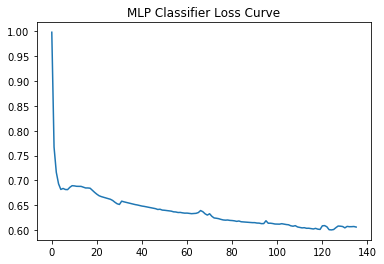

In [122]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

start = time.time()
clf = MLPClassifier(hidden_layer_sizes=(29, 30, 29), max_iter=800, tol=1e-19, activation='relu', solver='adam')
clf.fit(X_train, y_train)  # Fit data
prediction = clf.predict(X_test)  # Predict results for x_test
accs = accuracy_score(y_test, prediction)  # Accuracy Score
end = time.time()

print(f"{accs}: Elapsed time: {end-start} seconds.")

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title("MLP Classifier Loss Curve")
ax.plot(clf.loss_curve_)

fig.canvas.draw()

In [123]:
print(clf.__dict__)

# loss_values = history.history['loss']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, loss_values, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

{'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 800, 'loss': 'log_loss', 'hidden_layer_sizes': (29, 30, 29), 'shuffle': True, 'random_state': None, 'tol': 1e-19, 'verbose': False, 'warm_start': False, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': False, 'validation_fraction': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000, 'n_features_in_': 29, '_label_binarizer': LabelBinarizer(), 'classes_': array([-1,  1], dtype=int64), 'n_outputs_': 1, '_random_state': RandomState(MT19937) at 0x14EE8EA1048, 'n_iter_': 136, 't_': 91768720, 'n_layers_': 5, 'out_activation_': 'logistic', 'coefs_': [array([[ 1.41172045e+000, -8.65869341e-001, -1.09276373e-001,
        -8.95518389e-002, -2.56001278e+000, -2.07945365e+000,
        -1.07523194e+000, -2.49813625e-001, -7.79444131e-001,
         1.49731326e+000, -6.06193112e-0

In [150]:
from statistics import mean

df_holdouts_tweet_bal = df_holdouts[df_holdouts["f22_day_tweet_count"] > 0]
df_holdouts_bal = balance_df(df_holdouts_tweet_bal)

df_g_holdout = df_holdouts_bal.groupby(['f22_ticker', 'date'])

# model = clf

group_count = 0
acc_acc = []
group_preds = {}
for group_name, df_group in df_g_holdout:
    X_holdout = np.array(df_group[train_cols])
    y_holdout = np.array(df_group['buy_sell'])

    prediction = model.predict(X_holdout)
        
    pre_mean = sum(prediction)/len(prediction)
    pre_mean = [-1 if pre_mean < 0 else 1]
    
    pre_y_ho = sum(y_holdout)/len(y_holdout)
    pre_y_ho = [-1 if pre_y_ho < 0 else 1]

    accs_pre = accuracy_score([pre_y_ho], [pre_mean])
    acc_acc.append(accs_pre)
    
    ticker = group_name[0]
    date_str = group_name[1]
    if ticker in group_preds.keys():
        info = group_preds[ticker]
    else:
        info = {}
        group_preds[ticker] = info
    info[date_str] = pre_mean[0]
        
print(f"Mean: {mean(acc_acc)}")

g_tickers = []
for group_name, df_group in df_g_holdout:
    g_tickers.append(group_name[0])

df_samp_buy: 70206
df_samp_sell: 70206
Mean: 0.5438365194462755


In [151]:
amount = 9000
cash = 1000
num_trade = 4
roi_list = []
num_trades = 0

# NOTE: Add 'future_close' because this is the end of day price on low days that you will hit if the limit is not triggered.
raise Exception("Need future_close. Should not be selling at high. Should be selling at target roi - close if does not reach that number.".)

for tindex, ticker in enumerate(group_preds.keys()):
    info = group_preds[ticker]
    is_initialized = False
    for ndx, date_str in enumerate(info.keys()):
        
        prediction = info[date_str]
        should_buy = True if prediction == 1 else False
        df_test = df_holdouts[(df_holdouts["f22_ticker"] == ticker) & (df_holdouts["date"] == date_str)]
        close_list = df_test["original_close_price"].tolist()
        if len(close_list) == 0:
            continue
        
        close = close_list[0]
        
        if not is_initialized:
            num_shares = amount // close
            amount = num_shares * close
            cash += (amount / close) - (amount // close)
            is_initialized = True

        future_price = get_price_in_days(date_str, ticker)
        if future_price is not None:
            roi = close / future_price
            if roi >= 1:
                roi = -(roi - 1)
            else:
                roi = 1 - roi
            roi_list.append(roi)
        
        action = "bought"
        shares_price = num_trade * close
        if should_buy:
            if future_price is not None:
                if cash > shares_price:
                    cash -= shares_price
                    num_shares += num_trade
        else:
            action = "sold"
            if amount > shares_price:
                cash += shares_price
                num_shares -= num_trade
        
        if future_price is not None:
            amount = num_shares * future_price
            
        print(f"{ticker}; {action}; Date: {date_str}; close: {close}; fp: {future_price}; amount:{amount}; cash:{cash}")
        num_trades += 1

    cash += amount
    amount = cash * .9
    cash = cash * .1
    
    if num_trades > 20:
        break
    
#     cash += amount
#     amount += cash

print(f"Total: {cash + amount}; {cash}; {amount}; num_trades: {num_trades}; rois: {sum(roi_list)/len(roi_list)}")
    

AAL; sold; Date: 2020-08-13; close: 13.3; fp: 13.56; amount:9112.32; cash:1053.2
AAL; sold; Date: 2020-08-26; close: 12.785; fp: 14.26; amount:9525.68; cash:1104.3400000000001
AAL; sold; Date: 2020-09-04; close: 13.61; fp: 14.16; amount:9402.24; cash:1158.7800000000002
AAME; bought; Date: 2020-08-13; close: 2.095; fp: 2.19; amount:9942.6; cash:1048.722
AAME; bought; Date: 2020-08-14; close: 2.1; fp: 2.15; amount:9769.6; cash:1040.322
AAME; sold; Date: 2020-08-26; close: 1.9369999999999998; fp: 2.05; amount:9307.0; cash:1048.07
AAME; bought; Date: 2020-09-18; close: 2.14; fp: None; amount:9307.0; cash:1048.07
AAOI; sold; Date: 2020-08-13; close: 13.46; fp: 13.73; amount:9446.24; cash:1090.347
AAOI; sold; Date: 2020-08-14; close: 13.28; fp: 13.52; amount:9247.68; cash:1143.4669999999999
AAOI; sold; Date: 2020-08-26; close: 11.79; fp: 11.86; amount:8064.799999999999; cash:1190.627
AAOI; bought; Date: 2020-09-04; close: 10.52; fp: 10.46; amount:7154.64; cash:1148.547
AAON; sold; Date: 2020